# Temporal Segmentation Test Script

## Setup and Data Pre-Processing
- We need the data to be a series of images at set time steps so if we are passing in a video file or something like that, we need to convert it to a set of discrete images for SAM

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
import time
from IPython.display import display, clear_output
import json
import sys
sys.path.append('..')

from helper_functions import *

In [13]:
# get matching masks to previous frame and keep matching segmentations based on IOU using Hungarian algorithm
# good weights were 0.4, 0.05, 0.2, 0.2
# def get_matching_masks(prev_masks, curr_masks, iou_weight=0.3, dist_weight=0.1, size_diff_weight=0.3, shape_dissimilarity_weight=0.3):
def get_matching_masks(prev_masks, curr_masks, iou_weight=0.45, dist_weight=0.1, size_diff_weight=0.2, shape_dissimilarity_weight=0.4):
    n_prev_masks = len(prev_masks)
    n_curr_masks = len(curr_masks)
    
    # if there are no masks in the previous frame, then return all the masks in the current frame
    if n_prev_masks == 0:
        return list(range(n_curr_masks))
    
    # if there are no masks in the current frame, then return an empty list
    if n_curr_masks == 0:
        return []
    
    # compute the distance between each mask centroid in prev_masks and each mask centroid in curr_mask as a percentage of width and height
    distance_matrix = np.zeros((n_prev_masks, n_curr_masks))
    # compute the percent size difference between each mask in prev_masks and the corresponding mask in curr_masks
    percent_size_diff = np.zeros((n_prev_masks, n_curr_masks))
    # calculate IOU between all pairs of masks
    shape_dissimilarity_matrix = np.zeros((n_prev_masks, n_curr_masks))
    iou_matrix = np.zeros((n_prev_masks, n_curr_masks))
    cost_matrix = np.zeros((n_prev_masks, n_curr_masks))
    for i in range(n_prev_masks):
        for j in range(n_curr_masks):
            hu1 = hu_moments(prev_masks[i])
            hu2 = hu_moments(curr_masks[j])
            iou_matrix[i][j] = iou(prev_masks[i], curr_masks[j])
            shape_dissimilarity_matrix[i][j] = shape_dissimilarity(hu1, hu2)
            prev_centroid = np.mean(np.argwhere(prev_masks[i]), axis=0)
            curr_centroid = np.mean(np.argwhere(curr_masks[j]), axis=0)
            distance_matrix[i][j] = np.linalg.norm(prev_centroid - curr_centroid) / np.sqrt(prev_masks[i].shape[0] * prev_masks[i].shape[1])
            prev_area = np.sum(prev_masks[i])
            curr_area = np.sum(curr_masks[j])
            percent_size_diff[i][j] = (abs(prev_area - curr_area) / prev_area)
            # cost_matrix[i][j] = -iou_matrix[i][j] * iou_weight + distance_matrix[i][j] * dist_weight + percent_size_diff[i][j] * size_diff_weight + shape_dissimilarity_matrix[i][j] * shape_dissimilarity_weight
            cost_matrix[i][j] = (1-iou_matrix[i][j]) * iou_weight + distance_matrix[i][j] * dist_weight + percent_size_diff[i][j] * size_diff_weight + shape_dissimilarity_matrix[i][j] * shape_dissimilarity_weight
    
    # use scipy to solve the assignment problem
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # get the matching pairs of masks
    matching_pairs = []
    for i in range(len(row_ind)):
        # if iou_matrix[row_ind[i]][col_ind[i]] > iou_thresh:
        matching_pairs.append((row_ind[i], col_ind[i]))
    # matching_pairs = hungarian_algorithm(cost_matrix)

    # print weighted shape dissimilarity, iou, distance and size difference for each matching pair
    for i, j in matching_pairs:
        print(f'Weighted Shape Dissimilarity: {shape_dissimilarity_matrix[i][j] * shape_dissimilarity_weight}, IOU: {iou_matrix[i][j] * iou_weight}, Distance: {distance_matrix[i][j] * dist_weight}, Size Difference: {percent_size_diff[i][j] * size_diff_weight}')
    
    return matching_pairs

In [5]:
image_dir = '/home/yashas/Documents/thesis/segment-anything/test-images/group_0/traj0/images0/'
image_prefix = 'im_'
image_suffix = '.jpg'

In [7]:
big_plot_dim = 8

In [6]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

large_sam_checkpoint = "/home/yashas/Documents/thesis/segment-anything/sam_vit_h_4b8939.pth"
large_model_type = "vit_h"

# small_sam_checkpoint = "/home/yashas/Documents/thesis/segment-anything/sam_vit_b_01ec64.pth"
# small_model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[large_model_type](checkpoint=large_sam_checkpoint)
# sam = sam_model_registry[small_model_type](checkpoint=small_sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

## First image visualization and segmentation

In [8]:
image = cv2.imread(image_dir + image_prefix + '0' + image_suffix)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

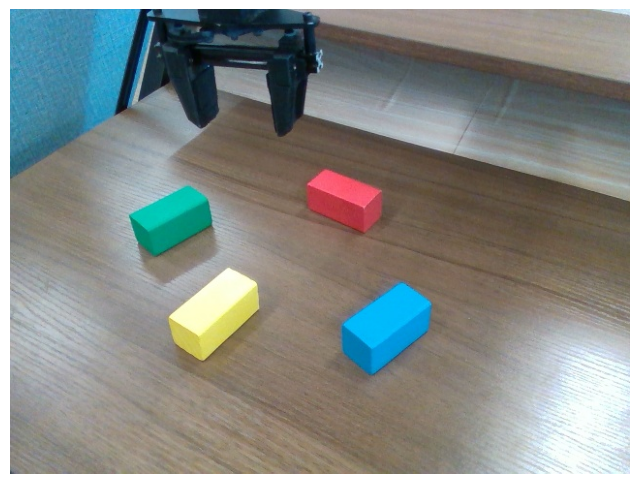

In [9]:
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.imshow(image)
plt.axis('off')
plt.show()

['test-images/group_0/traj0/images0/im_0.jpg'
 {'gripper_center': [[226, 42, 233, 50]], 'table_center': [[317, 278, 323, 285]], 'yellow_block_center': [[213, 306, 219, 311]], 'green_block_center': [[168, 209, 173, 214]], 'blue_block_center': [[391, 326, 395, 334]], 'red_block_center': [[341, 188, 345, 198]], 'yellow_block': [[159, 258, 261, 368]], 'green_block': [[120, 175, 212, 258]], 'blue_block': [[335, 275, 448, 382]], 'red_block': [[297, 155, 391, 237]], 'gripper': [[140, 0, 324, 138]], 'table': [[0, 69, 639, 479]]}]
torch.Size([6, 1, 480, 640])
(6, 480, 640)


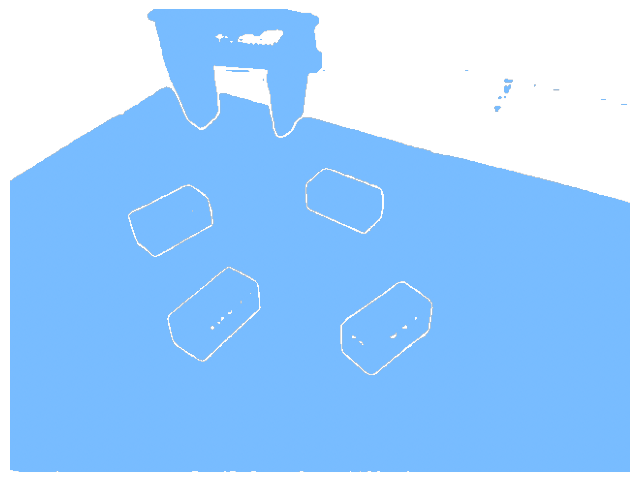

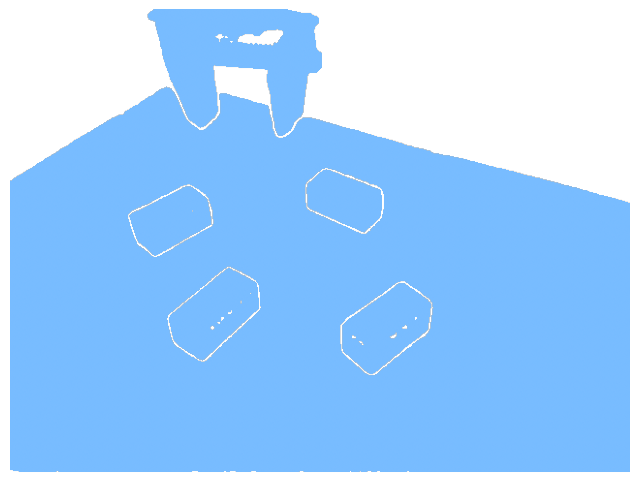

(1, 6, 480, 640)


In [10]:
# read testset_annotations.json file and get the annotations
json_file = "/home/yashas/Documents/thesis/thesis_working/testset_annotations.json"
annotations = get_annotations(json_file)

image_path = image_dir + image_prefix + '0' + image_suffix
image_path = image_path[image_path.index("test-images"):]

# get the annotations for the current image
curr_ann = None
for ann in annotations:
    if ann[0] == image_path:
        curr_ann = ann
        break
print(curr_ann)

# getting the bounding boxes and centroid points for each label
boxes = []
boxes.append(curr_ann[1]['gripper'][0])
boxes.append(curr_ann[1]['table'][0])
boxes.append(curr_ann[1]['yellow_block'][0])
boxes.append(curr_ann[1]['green_block'][0])
boxes.append(curr_ann[1]['blue_block'][0])
boxes.append(curr_ann[1]['red_block'][0])
input_boxes = torch.tensor(boxes, device=predictor.device)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])

points = []
points.append(curr_ann[1]['gripper_center'][0][:2])
points.append(curr_ann[1]['table_center'][0][:2])
points.append(curr_ann[1]['yellow_block_center'][0][:2])
points.append(curr_ann[1]['green_block_center'][0][:2])
points.append(curr_ann[1]['blue_block_center'][0][:2])
points.append(curr_ann[1]['red_block_center'][0][:2])
points_input = np.array([points])
for i in range(1, len(points)):
    points_input = np.append(points_input, [points], axis=0)
points_input = torch.tensor(points_input, device=predictor.device)
input_points = predictor.transform.apply_coords_torch(points_input, image.shape[:2])
labels = torch.diag(torch.ones(len(points), device=predictor.device))
first_frame_segs, scores, logits = predictor.predict_torch(
    point_coords=input_points,
    point_labels=labels,
    boxes = transformed_boxes,
    multimask_output = False,
)
print(first_frame_segs.shape)

# get the masks from the first frame
first_frame_masks = first_frame_segs.cpu().numpy()
first_frame_masks = first_frame_masks > 0.5
first_frame_masks = first_frame_masks.squeeze(1)
print(first_frame_masks.shape)

# combine the masks
combined_mask = combine_all_masks(first_frame_masks)

plt.figure(figsize=(big_plot_dim, big_plot_dim))
# plt.imshow(image)
show_mask(combined_mask, plt.gca())
plt.axis('off')
plt.show()

# get the largest contiguous section of each mask
for i in range(len(first_frame_masks)):
    first_frame_masks[i] = get_largest_contiguous(first_frame_masks[i])

combined_mask = combine_all_masks(first_frame_masks)

plt.figure(figsize=(big_plot_dim, big_plot_dim))
# plt.imshow(image)
show_mask(combined_mask, plt.gca())
plt.axis('off')
plt.show()

total_masks_over_time = np.array([first_frame_masks])
print(total_masks_over_time.shape)

## Segmentations over time of the rest of the images

In [11]:
# figure out how many images there are in the directory
import os

image_files = os.listdir(image_dir)
image_files = [f for f in image_files if f.endswith('.jpg')]
image_files = sorted(image_files)
n_images = len(image_files)
print(f"Found {n_images} images in the directory")

Found 47 images in the directory


In [14]:
box_margin = 0.2

# total_masks_over_time = np.array([[relevant_first_mask_anns[i]['segmentation'] for i in range(len(relevant_first_mask_anns))]])
# # the shape of this is [frame_num, mask_num, height, width]
# print(total_masks_over_time.shape)
total_masks_over_time = np.array([first_frame_masks])
print(total_masks_over_time.shape)
for i in range(1, n_images):
    frame_num = i
    image = cv2.imread(image_dir + image_prefix + str(frame_num) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    # get bounding boxes from previous masks
    boxes = [get_box(mask) for mask in total_masks_over_time[frame_num-1]]
    print("Frame Number: ", frame_num)
    # print(boxes)
    # inflate boxes
    for box in boxes:
        if box is not None:
            box[0] = max(0, box[0] - box_margin * (box[2] - box[0]))
            box[1] = max(0, box[1] - box_margin * (box[3] - box[1]))
            box[2] = min(image.shape[1], box[2] + box_margin * (box[2] - box[0]))
            box[3] = min(image.shape[0], box[3] + box_margin * (box[3] - box[1]))

    input_boxes = torch.tensor(boxes, device=predictor.device)

    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])

    # commented out since just the boxes give us terrible performance and we use the boxes later anyways
    masks, scores, logits = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=True,
    )

    masks = masks.cpu().numpy()
    curr_frame_first_masks = np.array([masks[i][j] for i in range(masks.shape[0]) for j in range(masks.shape[1])])

    centroids = np.array([find_centroid(mask) for mask in total_masks_over_time[frame_num-1]])
    masks_points = torch.tensor(centroids, device=predictor.device)
    points_for_display = masks_points.cpu().numpy()
    # reshape masks_points to be of shape (n_masks, 1, 2)
    masks_points = masks_points.unsqueeze(1)
    masks_labels = torch.ones(len(masks_points), device=predictor.device)
    labels_for_display = masks_labels.cpu().numpy()
    # reshape masks_labels to be of shape (n_masks, 1)
    masks_labels = masks_labels.unsqueeze(1)
    input_points = predictor.transform.apply_coords_torch(masks_points, image.shape[:2])
    # print("Masks Points: ")
    # print(masks_points.shape)
    mask_point_segs, scores, logits = predictor.predict_torch(
        point_coords=input_points,
        point_labels=masks_labels,
        boxes=transformed_boxes,
        multimask_output=True,
    )
    mask_point_segs = mask_point_segs.cpu().numpy()
    curr_frame_point_seg_masks = np.array([mask_point_segs[i][j] for i in range(mask_point_segs.shape[0]) for j in range(mask_point_segs.shape[1])])
    # print("Mask Point Segs:")
    # print(mask_point_segs.shape)
    # print("Curr Frame Point Seg Masks:")
    # print(curr_frame_point_seg_masks.shape)

    points_input = np.array([centroids])
    for i in range(1, len(centroids)):
        points_input = np.append(points_input, [centroids], axis=0)
    labels = torch.diag(torch.ones(len(centroids), device=predictor.device))
    points_input = torch.tensor(points_input, device=predictor.device)
    input_points = predictor.transform.apply_coords_torch(points_input, image.shape[:2])
    third_seg_masks, scores, logits = predictor.predict_torch(
        point_coords=input_points,
        point_labels=labels,
        boxes=None,
        multimask_output=True,
    )
    third_seg_masks = third_seg_masks.cpu().numpy()
    curr_frame_third_seg_masks = np.array([third_seg_masks[i][j] for i in range(third_seg_masks.shape[0]) for j in range(third_seg_masks.shape[1])])

    # plt.figure(figsize=(big_plot_dim, big_plot_dim))
    # # plt.imshow(image)
    # k = 0
    # for mask in third_seg_masks:
    #     # print(mask.shape)
    #     # get first element of mask but keep shape of mask
    #     mask = mask[1]
    #     # print(mask.shape)
    #     show_mask(mask, plt.gca(), color=np.array([color_list[k]]))
    #     k = k + 1
    # for box in input_boxes:
    #     show_box(box.cpu().numpy(), plt.gca())
    # for point in input_points:
    #     show_points(points_for_display, labels_for_display, plt.gca())
    # plt.axis('off')
    # plt.show()

    use_contiguous = True
    use_first_segmentation = False
    # flatten all multimasks into one masks array
    # create curr_frame_all_masks as numpy array with dimensions n_masks, height, width
    if use_first_segmentation:
        curr_frame_all_masks = np.array([curr_frame_first_masks[i] for i in range(len(curr_frame_first_masks))])
        curr_frame_all_masks = np.append(curr_frame_all_masks, curr_frame_point_seg_masks, axis=0)
    else:
        curr_frame_all_masks = np.array([curr_frame_point_seg_masks[i] for i in range(len(curr_frame_point_seg_masks))])
    # merge curr_frame_all_masks with curr_frame_point_seg_masks
    curr_frame_all_masks = np.append(curr_frame_all_masks, curr_frame_third_seg_masks, axis=0)
    # get contiguous sections of each mask
    contiguous_all_masks = np.array([get_largest_contiguous(mask) for mask in curr_frame_all_masks])
    # print("Curr Frame All Masks:")
    # print(curr_frame_all_masks.shape)
    # compute matching pairs between masks and total_masks_over_time[frame_num]
    if not use_contiguous:
        matching_pairs = get_matching_masks(total_masks_over_time[frame_num-1], curr_frame_all_masks)
        matching_masks = [curr_frame_all_masks[pair[1]] for pair in matching_pairs]
    else:
        matching_pairs = get_matching_masks(total_masks_over_time[frame_num-1], contiguous_all_masks)
        matching_masks = [contiguous_all_masks[pair[1]] for pair in matching_pairs]
    print("Matching Pairs:")
    print(matching_pairs)
    total_masks_over_time = np.append(total_masks_over_time, np.array([matching_masks]), axis=0)
    print(total_masks_over_time.shape)

(1, 6, 480, 640)
Frame Number:  1
Weighted Shape Dissimilarity: 0.00042769270212820586, IOU: 0.43248725719796116, Distance: 0.0001392779954098441, Size Difference: 0.00792320366788452
Weighted Shape Dissimilarity: 2.213549614578647e-06, IOU: 0.4482722876652359, Distance: 4.515401057821912e-05, Size Difference: 6.553013882307872e-05
Weighted Shape Dissimilarity: 0.00019089107030794198, IOU: 0.44339258114374036, Distance: 2.8095804685990636e-05, Size Difference: 0.0023492560689115116
Weighted Shape Dissimilarity: 7.856132601596826e-06, IOU: 0.4462898936170213, Distance: 1.6407615229119424e-05, Size Difference: 0.0008027829810008029
Weighted Shape Dissimilarity: 0.00019786958016644962, IOU: 0.4420593204430261, Distance: 1.9181114401499417e-05, Size Difference: 0.00343839541547278
Weighted Shape Dissimilarity: 1.6114084060118504e-05, IOU: 0.44722466960352425, Distance: 8.599337620525214e-06, Size Difference: 0.000294811320754717
Matching Pairs:
[(0, 1), (1, 22), (2, 26), (3, 9), (4, 13), (

### Visualization

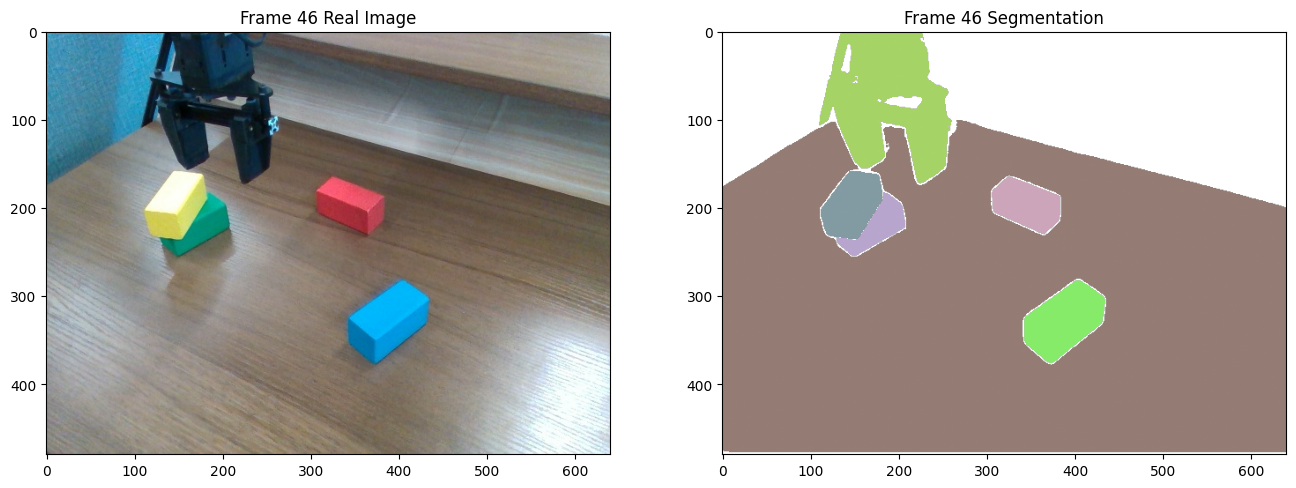

In [15]:
# Visualize the total_masks_over_time as an animation, with each mask in each frame being a different color, side by side with the real image, for comparison
for i in range(0, n_images):
    image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(big_plot_dim*2, big_plot_dim*2))
    plt.subplot(1, 2, 1)
    plt.title(f"Frame {i} Real Image")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title(f"Frame {i} Segmentation")
    show_all_masks = True
    masks_to_show = [2]
    for j in range(len(total_masks_over_time[i])):
        if show_all_masks:
            show_mask(total_masks_over_time[i][j], plt.gca(), color=np.array(color_list[j]))
        elif j in masks_to_show:
            show_mask(total_masks_over_time[i][j], plt.gca(), color=np.array(color_list[j]))
    # output each frame in animation to file
    # plt.savefig(f"frame_{i}.png")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

In [ ]:
# Visualize the total_masks_over_time, with each mask in each frame being a different color
# n = total_masks_over_time.shape[0]
# cols = 4
# rows = n // cols + 1
# plt.figure(figsize=(16, 16))
# for i in range(n):
#     plt.subplot(rows, cols, i + 1)
#     plt.title(f"Frame {i}")
#     for j in range(len(total_masks_over_time[i])):
#         show_mask(total_masks_over_time[i][j], plt.gca(), color=np.array(color_list[j]))
#     plt.axis('off')


In [ ]:
# Visualize all images in directory as animation
# for i in range(0, n_images):
#     image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize=(big_plot_dim, big_plot_dim))
#     plt.title(f"Frame {i}")
#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()
#     time.sleep(0.1)
#     clear_output(wait=True)

In [ ]:
# Visualize the total_masks_over time as an animation and in the same plot as the real image, for comparison
# for i in range(0, n_images):
#     image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize=(big_plot_dim, big_plot_dim))
#     plt.title(f"Frame {i}")
#     plt.imshow(image)   # Comment this line to see only the masks
#     for j in range(len(total_masks_over_time[i])):
#         show_mask(total_masks_over_time[i][j], plt.gca(), color=np.array(color_list[j]))
#     plt.axis('off')
#     plt.show()
#     time.sleep(0.1)
#     clear_output(wait=True)

### Pickling necessary results for use with algorithmic tokenizer

In [ ]:
import pickle

out_path = image_dir + 'total_masks_over_time.pkl'
with open(out_path, 'wb') as f:
    pickle.dump(total_masks_over_time, f)